Понятие как ***random seed***, это можно интерпретировать, как номер последовательности случайных чисел, которую выдаст нам случайный генератор, если его попросить выдать нам последовательность. Случайных генераторов есть несколько: есть случайный генератор модуля random в Питоне, есть случайный генератор модуля numpy.random (уже библиотеки numpy), есть также случайные генераторы библиотеки PyTorch, и другие. Давайте зафиксируем их все.

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

 Для примера используем датасет классификации вин. Есть такой известный датасет, он есть и в библиотеке scikit.learn. Мы можем его загрузить через sklearn.datasets.load_wine(). И этот датасет будет содержать 178 различных бутылок вин, у каждой бутылки будет померено 13 параметров, это вещественные числа, и там будет три класса, на которые можно классифицировать конкретную бутылку.

In [2]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

Теперь нам нужно этот датасет разбить на две части: на трейновую часть, на которой мы будем обучаться, и на тестовую, на которой мы будем считать метрики. Воспользуемся функцией train_test_split из той же библиотеки scikit_learn. Если мы передадим в функцию train_test_split первым параметром, собственно, dataset (тут мы используем только первые две колонки, колонок 13, столько же, сколько у нас параметров вина, мы используем всего две для удобства последующей визуализации), вторым параметром мы передадим таргеты, то есть те классы, которые нам нужно предсказать -- это будет номер класса (такая колонка), и мы скажем что мы отрежем 30 процентов в тест, и перед тем, как нам этот датасет делить на две части, нам нужно его перемешать, чтобы удостовериться, что если он был отсортирован, например по номеру класса, то теперь эта сортировка не работает.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2], 
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

## Задача
Фиксирование seed не гарантирует, что код будет одинаково выполняться на разных компьютерах. Но на одной и той же машине вы будете получать одинаковые результаты, перезапуская один и тот же скрипт.

Например, функция random.randint(start, end) отдает случайное целое число в диапазоне от start, end (включительно). Запуская скрипт, состоящий из вызова этой функции, вы будете получать разные ответы. 

В этом задании вам нужно подобрать seed, чтобы функция random.randint(0, 10) выдала число 5

PS: надо понимать, что фиксирование random seed не приведет к тому, что повторный вызов random.randint(0, 10) внутри того же скрипта снова даст 5. 

In [10]:
# import random
# for i in range(10):
#   random.seed(i)
#   print(f'i: {i} ---', random.randint(0, 10))
# # Хех случайности не случайны

i: 0 --- 6
i: 1 --- 2
i: 2 --- 0
i: 3 --- 3
i: 4 --- 3
i: 5 --- 9
i: 6 --- 9
i: 7 --- 5
i: 8 --- 3
i: 9 --- 7


## Нейросеть
После этого мы все эти "фолды": *X_train, X_test, Y_train* и *Y_test* обернём в torch тензоры -- те, которые -- дробные числа, мы обернём в float тензор, если числа не дробные, обернём в long тензор.

 Отлично, теперь реализуем класс, назовём его ***WineNet***,  это будет наша нейросеть для классификации. Точно так же, как нейросеть для синуса, которая была в прошлый раз, мы отнаследуемся от **torch.nn.Module**, в функции __init__ (в конструкторе этого) класса будет некоторый аргумент: это количество скрытых нейронов, n_hidden_neurons.
 
  В этот раз мы попробуем два скрытых слоя, то есть наша нейросеть будет состоять всего из трёх слоёв, и два из них будут скрыты. То есть первый слой -- это fully connected слой, из двух входов (у нас две колонки для каждой бутылки вина), на выходе N скрытых нейронов, дальше активация: сигмоида, можно поставить любую другую, если хотите.
  
   После этого -- скрытый слой, который из N нейронов, превращает их тоже в N нейронов, Снова сигмоидная активация. 
   
   После этого снова fully connected слой, который выдаёт нам три нейрона, каждый нейрон будет отвечать за свой класс. То есть на выходе этих трёх нейронов будут некоторые числа, которые после этого мы передадим в софтмакс, и получим вероятности классов. 
   Собственно, этот софтмакс дальше у нас инициализируется.
   
   И напишем функцию "forward" -- она будет реализовывать граф нашей нейронной сети. Мы передаём двухмерный тензор с двумя колоннами в первый fully connected слой, после этого в первую активацию, во второй fully connected слой, во вторую активацию, в третий fully connected слой, у которого три выхода. И заметьте, мы здесь не использовали softmax. Почему мы так сделали? Почему мы не прогнали выход из третьего слоя через softmax? Дело в том, что после того, как мы посчитаем выходы нейронной сети, мы хотим прогнать их через softmax и посчитать кросс-энтропию. Но если вы помните формулу кросс-энтропии, там есть логарифм, то есть выходы нейронной сети прогоняются через логарифм. А softmax тоже, если вы помните формулу, в нем участвуют экспоненты. Так вот, эти экспоненты и логарифмы взаимно уничтожаются, и получается что нам не нужно вычислять экспоненты, чтобы посчитать кросс-энтропию. Мы можем её посчитать даже не считая softmax. Соответственно, если мы хотим просто считать лоссы, нам softmax не нужен. Если мы хотим посчитать вероятности, то нам придётся использовать softmax.

In [4]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5)

In [5]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), 
                             lr=1.0e-3)

In [6]:
np.random.permutation(5)

array([2, 0, 1, 4, 3])

В прошлый раз мы брали весь наш датасет, считали по нему loss-функцию, дальше делали градиентный шаг, и повторяли этот процесс многократно. Но в реальной жизни вряд ли поместится в памяти весь датасет. То есть, обучение в реальной жизни происходит по частям данных -- они называются батчи (batch). Мы должны отрезать некоторый кусочек наших данных, посчитать по нему loss, посчитать по нему градиентный шаг, сделать градиентный шаг, взять следующий кусочек, и так далее, вот так этот процесс проделывать. Соответственно, одна эпоха, то есть итерация просмотра всего датасета, у нас бьётся на много маленьких частей. Здесь вот, эту разбивку, мы будем делать следующим образом. Нам понадобится функция numpy.random.permutation. Что делает эта функция? Вот, если мы вызовем её с аргументом "5", она даст нам numpy.array размером "5", с числами от 0 до 4 включительно, случайно перемешанными. Если мы сюда подставим размер нашего трейнового датасета, то мы получим некоторые индексы, в случайном порядке. И получается, что если мы от нашего датасета возьмём эти индексы, то мы получим "пошафленный", перемешанный датасет. Вот, каждую эпоху мы будем шаффлить датасет, и потом резать его на части. Скажем, что эти части будут размером десять элементов. Можно взять любое другое значение. Итак, каждую эпоху мы будем перемешивать наш датасет, у нас есть переменная "order", которая определяется каждую эпоху, которая говорит порядок индексов, который нужно применить к датасету. Вот этот порядок: из него мы будем вырезать участочки длиной batch_size. То есть, каждую эпоху мы будем делать перемешивание нашего датасета, определять переменную order, которая отвечает за порядок элементов. А после этого мы из этого порядка будем вычислять некоторое подмножество, начиная со start_index, который будет 0, 10, 20 и так далее, до конца батча. То есть, если start index "0", то конец будет 0 плюс 10, значит 10-й индекс в конец не включается. И получается, что batch_indexes -- это некоторые индексы, которые соответствуют текущему батчу. Таким образом мы каждую эпоху гарантированно проходим все значения в датасете, при этом каждая итерация обучения происходит по десяти элементам. Вот эти batch_indexes, мы их возьмём из X_train и y_train, чтобы получить и данные, и ответы. Сделаем fowrard, то есть пропустим весь батч через нейросеть, получим некоторые prediction. Напомню, это без софтмакса, то есть это выходы на последних трех нейронах. После этого посчитаем loss на выходах нейронной сети и реальных значениях, и посчитаем backward, то есть у результата выполнения loss функции, мы посчитаем производную. А результат этой производной, то есть градиенты, которые получились, окажутся у нас в оптимайзере, потому что он оборачивает все веса нейронной сети. Далее оптимайзер может сделать step, то есть шаг градиентного спуска.

Каждые 100 эпох мы будем вычислять метрики на тестовом датасете чтобы посмотреть, обучается у нас нейросеть, или нет. То есть каждые 100 эпох мы делаем forward по тестовым данным, получаем тестовые prediction, и вычисляем, какой выход был максимальный. То есть опять же чтобы понять, какой класс предсказывает нейросеть, не обязательно вычислять софтмакс, не обязательно вычислять вероятности. Нам достаточно посмотреть: а какой выход был наибольший, и он же и будет впоследствии выходом с максимальной вероятностью. То есть нам нужно посчитать argmax у выходов нейронной сети, это будет номер нейрона, и сравнить его с тем номером класса, который находится в Y_test. После этого мы хотим посчитать: а какая доля вот этого совпадения, когда у нас нейрон с максимальным выходом совпал с реально правильным классом. Нам нужно посчитать среднее значение, но среднее значение мы не можем посчитать у целочисленного тензора, который получается в результате этого сравнения, поэтому мы сначала его превратим к дробному тензору и вызовем у него метод mean(), и будем его распечатывать.

In [7]:
batch_size = 10

for epoch in range(5000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)
        print((test_preds == y_test).float().mean())

tensor(0.4074)
tensor(0.4074)
tensor(0.4630)
tensor(0.5000)
tensor(0.4259)
tensor(0.4074)
tensor(0.5185)
tensor(0.5185)
tensor(0.4444)
tensor(0.4259)
tensor(0.5000)
tensor(0.5370)
tensor(0.5370)
tensor(0.5370)
tensor(0.7407)
tensor(0.6852)
tensor(0.6481)
tensor(0.6852)
tensor(0.6667)
tensor(0.6852)
tensor(0.6852)
tensor(0.6852)
tensor(0.7222)
tensor(0.7037)
tensor(0.7407)
tensor(0.7593)
tensor(0.7778)
tensor(0.7963)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8333)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)


### Визуализируем результат

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


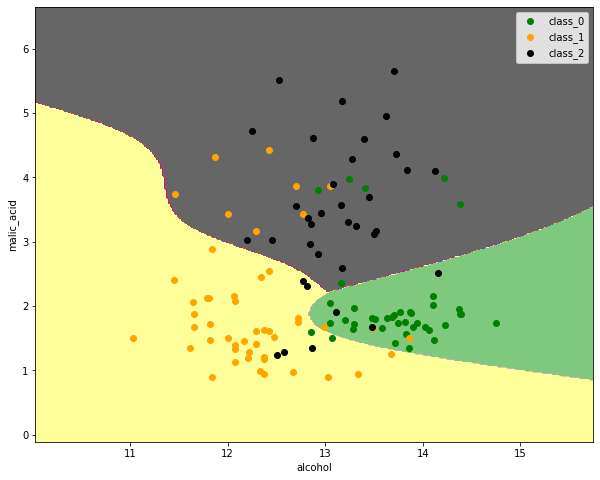

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()